In [4]:
import pandas as pd
from PIL import Image
pd.set_option('display.max_colwidth', None)

In [5]:
df_train = pd.read_csv('./Data/df_train.csv')
df_val = pd.read_csv('./Data/df_val.csv')

In [6]:
df_val

,Index,Image_Path,Target_Path
0,munster_000025_000019,./Data/files/Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/val/munster/munster_000025_000019_leftImg8bit.png,./Data/files/Cityscapes_gtFine_trainvaltest/gtFine/val/munster/munster_000025_000019_gtFine_polygons.json
1,munster_000156_000019,./Data/files/Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/val/munster/munster_000156_000019_leftImg8bit.png,./Data/files/Cityscapes_gtFine_trainvaltest/gtFine/val/munster/munster_000156_000019_gtFine_polygons.json
2,munster_000050_000019,./Data/files/Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/val/munster/munster_000050_000019_leftImg8bit.png,./Data/files/Cityscapes_gtFine_trainvaltest/gtFine/val/munster/munster_000050_000019_gtFine_polygons.json
3,munster_000123_000019,./Data/files/Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/val/munster/munster_000123_000019_leftImg8bit.png,./Data/files/Cityscapes_gtFine_trainvaltest/gtFine/val/munster/munster_000123_000019_gtFine_polygons.json
4,munster_000091_000019,./Data/files/Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/val/munster/munster_000091_000019_leftImg8bit.png,./Data/files/Cityscapes_gtFine_trainvaltest/gtFine/val/munster/munster_000091_000019_gtFine_polygons.json
...,...,...,...
495,frankfurt_000001_037705,./Data/files/Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/val/frankfurt/frankfurt_000001_037705_leftImg8bit.png,./Data/files/Cityscapes_gtFine_trainvaltest/gtFine/val/frankfurt/frankfurt_000001_037705_gtFine_polygons.json
496,frankfurt_000000_014480,./Data/files/Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/val/frankfurt/frankfurt_000000_014480_leftImg8bit.png,./Data/files/Cityscapes_gtFine_trainvaltest/gtFine/val/frankfurt/frankfurt_000000_014480_gtFine_polygons.json
497,frankfurt_000001_051807,./Data/files/Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/val/frankfurt/frankfurt_000001_051807_leftImg8bit.png,./Data/files/Cityscapes_gtFine_trainvaltest/gtFine/val/frankfurt/frankfurt_000001_051807_gtFine_polygons.json
498,frankfurt_000001_066574,./Data/files/Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/val/frankfurt/frankfurt_000001_066574_leftImg8bit.png,./Data/files/Cityscapes_gtFine_trainvaltest/gtFine/val/frankfurt/frankfurt_000001_066574_gtFine_polygons.json


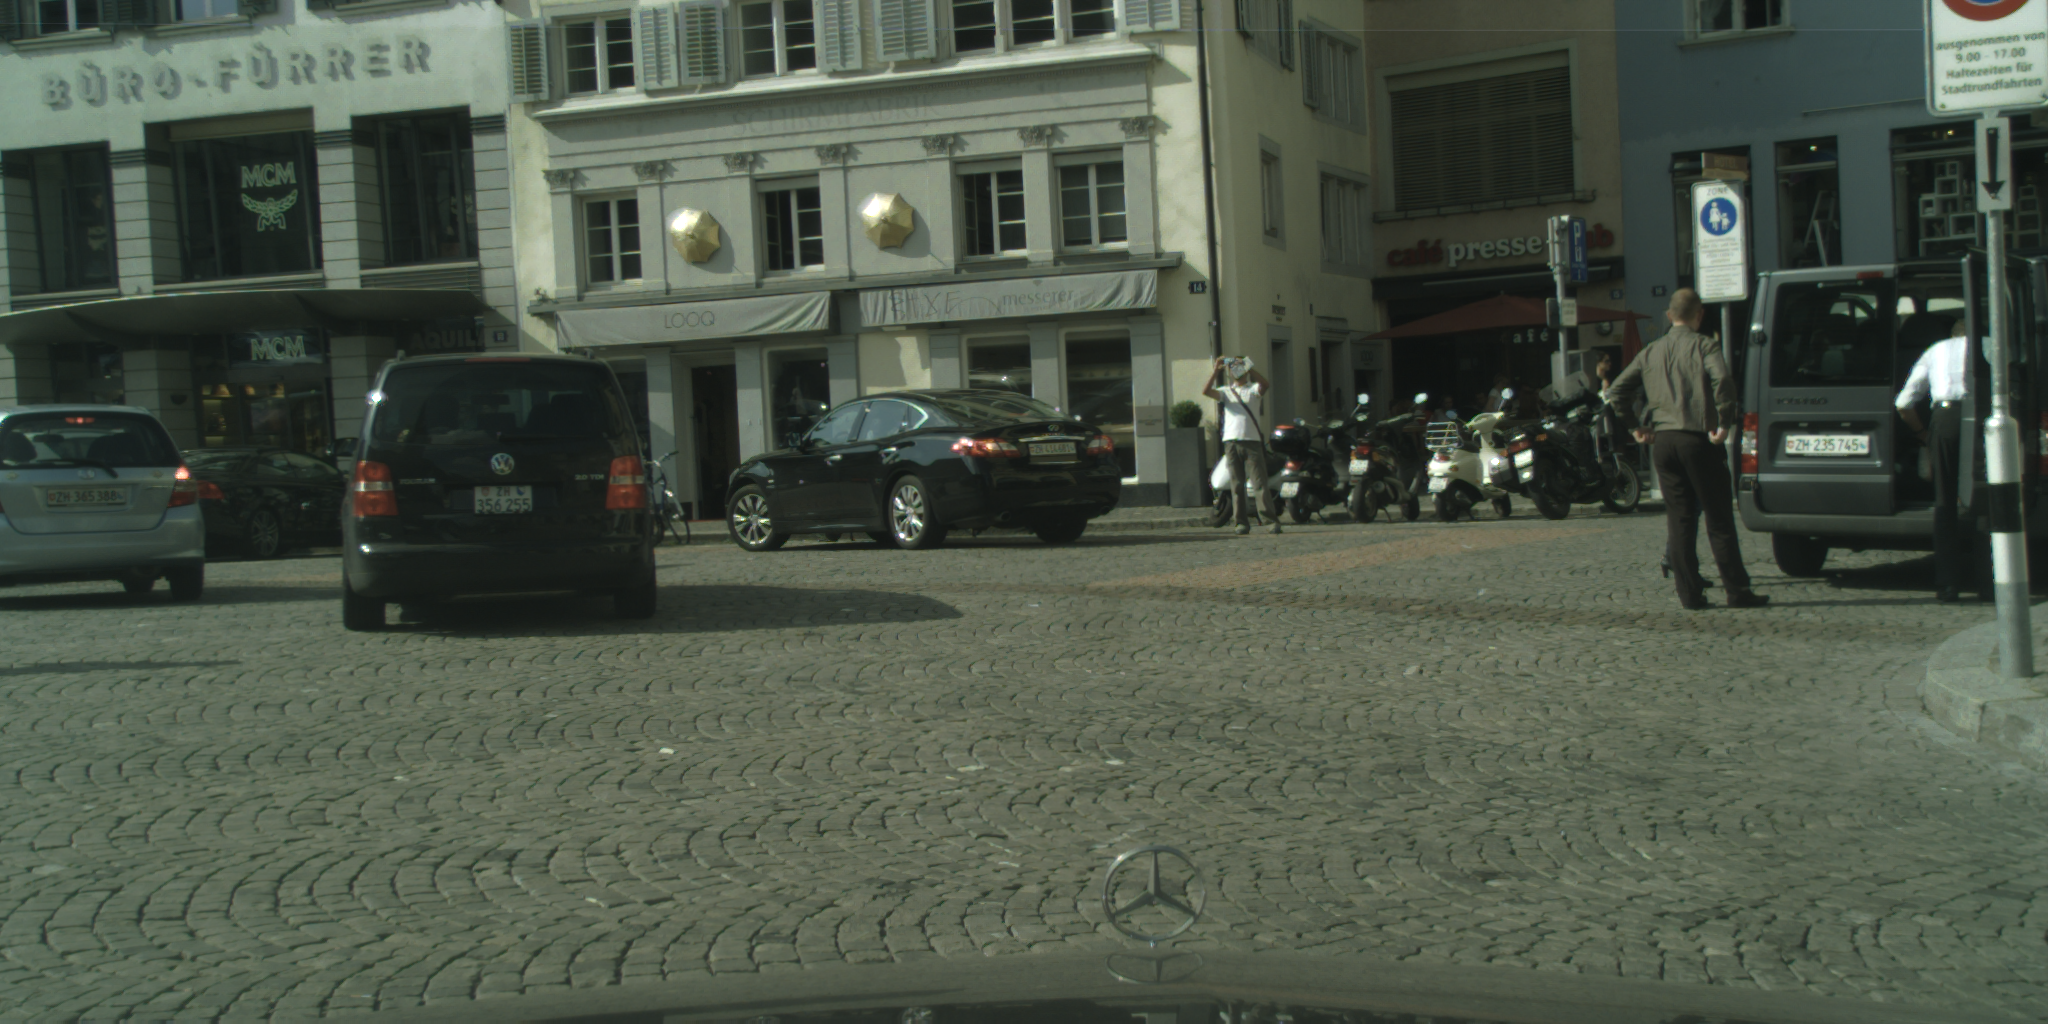

In [7]:
img_path = Image.open(df_train['Image_Path'].iloc[0])
img_path

In [40]:
import pandas as pd
import json
import numpy as np
import cv2
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, UpSampling2D, Input

In [41]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(None, None, 3))

# Ajouter des couches supplémentaires pour la segmentation
x = base_model.output
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(1, (1, 1), activation='sigmoid')(x)

# Créer le modèle de segmentation
model = Model(inputs=base_model.input, outputs=x)

# Prétraiter les données
def preprocess_image(image_path, target_size=(224, 224)):
    image = cv2.imread(image_path)
    image = cv2.resize(image, target_size)
    image = preprocess_input(image)
    return image

# Générer les masques de segmentation à partir des polygones
def generate_segmentation_mask(json_data, img_height, img_width):
    mask = np.zeros((img_height, img_width))
    for obj in json_data['objects']:
        label = obj['label']
        polygon = np.array(obj['polygon'])
        cv2.fillPoly(mask, [polygon], 255)
    return mask.reshape((1, img_height, img_width, 1))

# Boucler à travers chaque ligne du DataFrame
for index, row in df_train.iterrows():
    image_path = row['Image_Path']
    json_path = row['Target_Path']

    # Charger les données JSON
    with open(json_path, "r") as file:
        json_data = json.load(file)

    # Prétraiter l'image et générer le masque
    image = preprocess_image(image_path)
    mask = generate_segmentation_mask(json_data, img_height=json_data['imgHeight'], img_width=json_data['imgWidth'])

In [46]:
image_path

'./Data/files/Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/train/bremen/bremen_000099_000019_leftImg8bit.png'

In [43]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [44]:
model.fit(image, mask, epochs=10, batch_size=32, validation_split=0.2)

ValueError: Data cardinality is ambiguous. Make sure all arrays contain the same number of samples.'x' sizes: 179
'y' sizes: 1
